In [12]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
import kagglehub

path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fruit-and-vegetable-image-recognition' dataset.
Path to dataset files: /kaggle/input/fruit-and-vegetable-image-recognition


In [14]:
import os

print("Your dataset folder:")
print(path)
print("\nContents inside it:")
print(os.listdir(path))

Your dataset folder:
/kaggle/input/fruit-and-vegetable-image-recognition

Contents inside it:
['validation', 'test', 'train']


In [15]:
# This is your dataset path
dataset_root = "/kaggle/input/fruit-and-vegetable-image-recognition"

# Folders already present
train_dir = f"{dataset_root}/train"
val_dir   = f"{dataset_root}/validation"
test_dir  = f"{dataset_root}/test"

import os
print("Train subfolders:", os.listdir(train_dir))
print("Validation subfolders:", os.listdir(val_dir))
print("Test subfolders:", os.listdir(test_dir))


Train subfolders: ['capsicum', 'sweetcorn', 'orange', 'tomato', 'turnip', 'ginger', 'raddish', 'pomegranate', 'pineapple', 'jalepeno', 'apple', 'carrot', 'lettuce', 'bell pepper', 'eggplant', 'beetroot', 'kiwi', 'pear', 'cabbage', 'cauliflower', 'paprika', 'lemon', 'sweetpotato', 'grapes', 'cucumber', 'corn', 'banana', 'garlic', 'chilli pepper', 'watermelon', 'mango', 'peas', 'onion', 'potato', 'spinach', 'soy beans']
Validation subfolders: ['capsicum', 'sweetcorn', 'orange', 'tomato', 'turnip', 'ginger', 'raddish', 'pomegranate', 'pineapple', 'jalepeno', 'apple', 'carrot', 'lettuce', 'bell pepper', 'eggplant', 'beetroot', 'kiwi', 'pear', 'cabbage', 'cauliflower', 'paprika', 'lemon', 'sweetpotato', 'grapes', 'cucumber', 'corn', 'banana', 'garlic', 'chilli pepper', 'watermelon', 'mango', 'peas', 'onion', 'potato', 'spinach', 'soy beans']
Test subfolders: ['capsicum', 'sweetcorn', 'orange', 'tomato', 'turnip', 'ginger', 'raddish', 'pomegranate', 'pineapple', 'jalepeno', 'apple', 'carrot'

In [16]:
import os, numpy as np, tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

ROOT = "/kaggle/input/fruit-and-vegetable-image-recognition"
TRAIN_DIR, VAL_DIR, TEST_DIR = f"{ROOT}/train", f"{ROOT}/validation", f"{ROOT}/test"

FRUIT_CLASSES = {
    'orange','pomegranate','pineapple','apple','kiwi','pear',
    'lemon','grapes','banana','watermelon','mango'
}
ALL_CLASSES = set(os.listdir(TRAIN_DIR))
VEG_CLASSES = ALL_CLASSES - FRUIT_CLASSES
print("Fruits:", sorted(FRUIT_CLASSES))
print("Vegetables:", sorted(VEG_CLASSES))

IMG_SIZE = (150,150)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE
IMG_EXTS = ('.jpg','.jpeg','.png','.bmp','.gif','.tiff')

def collect_files_and_labels(split_dir):
    files, labels = [], []
    for cls in sorted(os.listdir(split_dir)):
        cls_path = os.path.join(split_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        label = 1 if cls in FRUIT_CLASSES else 0
        for r,_,names in os.walk(cls_path):
            for n in names:
                if n.lower().endswith(IMG_EXTS):
                    files.append(os.path.join(r,n))
                    labels.append(label)
    return np.array(files), np.array(labels, dtype=np.int32)

train_files, train_labels = collect_files_and_labels(TRAIN_DIR)
val_files,   val_labels   = collect_files_and_labels(VAL_DIR)
test_files,  test_labels  = collect_files_and_labels(TEST_DIR)

print(len(train_files), len(val_files), len(test_files))


Fruits: ['apple', 'banana', 'grapes', 'kiwi', 'lemon', 'mango', 'orange', 'pear', 'pineapple', 'pomegranate', 'watermelon']
Vegetables: ['beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'jalepeno', 'lettuce', 'onion', 'paprika', 'peas', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip']
3115 351 359


In [17]:
def load_image(path, label, img_size=IMG_SIZE):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)/255.0
    return img, tf.cast(label, tf.float32)

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def make_ds(files, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if training:
        ds = ds.shuffle(min(len(files), 2048), reshuffle_each_iteration=True)
    ds = ds.map(lambda p,l: load_image(p,l), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH).prefetch(AUTOTUNE)

train_ds = make_ds(train_files, train_labels, training=True)
val_ds   = make_ds(val_files,   val_labels,   training=False)
test_ds  = make_ds(test_files,  test_labels,  training=False)


In [18]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE[0],IMG_SIZE[1],3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1,activation='sigmoid')  # Fruit=1, Veg=0
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,563,713 (36.48 MB)

 Trainable params: 9,563,713 (36.48 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

EPOCHS = 6  # increase later if you want
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


Epoch 1/6
98/98 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6527 - loss: 0.7636 - val_accuracy: 0.7265 - val_loss: 0.5555 - learning_rate: 0.0010
Epoch 2/6
98/98 ━━━━━━━━━━━━━━━━━━━━ 106s 739ms/step - accuracy: 0.6991 - loss: 0.5648 - val_accuracy: 0.7493 - val_loss: 0.5064 - learning_rate: 0.0010
Epoch 3/6
98/98 ━━━━━━━━━━━━━━━━━━━━ 76s 775ms/step - accuracy: 0.7349 - loss: 0.5646 - val_accuracy: 0.7692 - val_loss: 0.4616 - learning_rate: 0.0010
Epoch 4/6
98/98 ━━━━━━━━━━━━━━━━━━━━ 72s 738ms/step - accuracy: 0.7618 - loss: 0.5034 - val_accuracy: 0.7692 - val_loss: 0.4624 - learning_rate: 0.0010
Epoch 5/6
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 781ms/step - accuracy: 0.7704 - loss: 0.4814 - val_accuracy: 0.7692 - val_loss: 0.4425 - learning_rate: 0.0010
Epoch 6/6
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 773ms/step - accuracy: 0.7634 - loss: 0.4823 - val_accuracy: 0.8519 - val_loss: 0.3670 - learning_rate: 0.0010


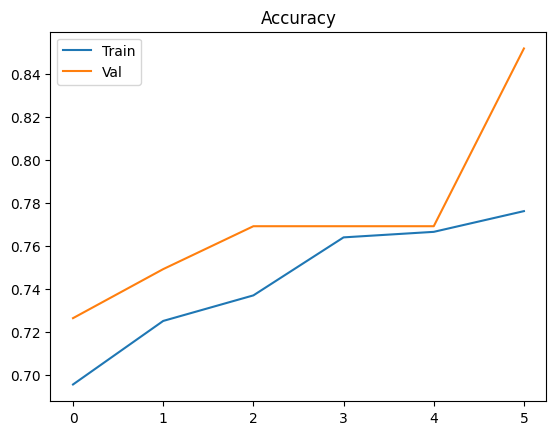

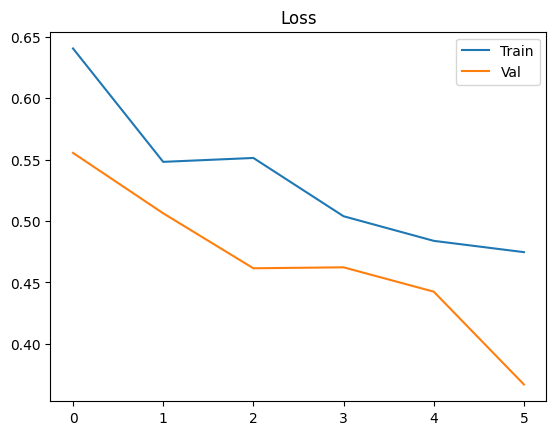

Validation Accuracy: 85.19%
Test Accuracy: 85.24%


In [20]:
import matplotlib.pyplot as plt

plt.figure(); plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy'])
plt.title('Accuracy'); plt.legend(['Train','Val']); plt.show()

plt.figure(); plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
plt.title('Loss'); plt.legend(['Train','Val']); plt.show()

val_loss, val_acc = model.evaluate(val_ds, verbose=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")


In [21]:
model.save("/kaggle/working/fruit_vs_veg_binary.h5")
print("Saved: /kaggle/working/fruit_vs_veg_binary.h5")


Saved: /kaggle/working/fruit_vs_veg_binary.h5
